# Slot Attention を再現する
Google Researchが発表した「動画から物体を個別に切り出し、時間的に追跡・予測する」というタスクのデファクトスタンダードとなっているSlot Attention for Video(以下略SAVi)を再現実装する






## なぜこのモデルが本研究においてベースラインとして最適か

*   入力が動画でピクセルであるという点
*   物体ごとに分離して学習しているという点
*   物体は見た目に依存しているという点
*   時間経過でトラッキングが起きやすいという点
*   複雑なテクスチャの実写映像に弱いという点











## 本研究で言いたいこと

物体の見た目だけを捉え意味を捉えていないSAViと物体の意味を捉えた本研究を比べ、意味を捉えていると物理的一貫性が確立されやすく、覚えることが少ないため、メモリ効率が良いということを示したい。

## 使用するデータセット
意味（appearance）と位置（pose / motion）を分離できているか」を、
動画レベルで厳密に評価できる**MOVi**を使用する。

MOVi は以下を全て満たします。

| 要件                         | MOVi                          |
| -------------------------- | ----------------------------- |
| 動画データ                      | ✅                             |
| 複数オブジェクト                   | ✅                             |
| オブジェクト中心表現                 | ✅（instance segmentation GTあり） |
| 位置変化（運動）                   | ✅                             |
| 視点変化                       | ✅                             |
| 遮蔽（occlusion）              | ✅                             |
| 長期依存（temporal consistency） | ✅                             |
| 定量評価しやすい                   | ✅（mask / tracking / depth）    |

まず再現性を一旦確保したいので**MOVi-A**を使用する。今後MOVi-D、MOVi-Eを使用していきたい。また動画長は30にする。




In [ ]:
# @title 1. ライブラリのインストールとインポート
# 高速化と動画保存に必要なライブラリ
!pip install -q imageio[ffmpeg] scikit-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import adjusted_rand_score
import os
import time

# GPU設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 再現性のためのSeed固定
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

Using device: cuda


In [ ]:
# @title 2. データセット定義 (MOVi-A互換・高速軽量版)

class SyntheticMOViDataset(Dataset):
    """
    MOVi-Aの特性（単純な3D/2D形状、移動、オクルージョン）を模倣し、
    オンザフライで生成する軽量データセット。
    """
    def __init__(self, num_samples=100, seq_len=100, resolution=(64, 64), num_objects=3): # seq_lenを100に変更
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.res = resolution
        self.num_objects = num_objects

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # ランダムな移動物体（円）を含む動画を生成
        c, h, w = 3, self.res[0], self.res[1]
        video = torch.zeros(self.seq_len, c, h, w)
        masks = torch.zeros(self.seq_len, self.num_objects + 1, h, w) # +1 for background

        # 背景 (黒)
        masks[:, 0, :, :] = 1.0

        for obj_i in range(self.num_objects):
            # 初期位置と速度
            pos = np.random.rand(2) * 0.8 + 0.1
            vel = (np.random.rand(2) - 0.5) * 0.03 # 動きが速すぎないよう速度を少し調整
            color = np.random.rand(3)
            radius = 0.1 + np.random.rand() * 0.05

            for t in range(self.seq_len):
                # 移動とバウンス
                pos += vel
                for dim in range(2):
                    if pos[dim] < radius or pos[dim] > 1 - radius:
                        vel[dim] *= -1

                # 描画 (簡易的な円)
                y_grid, x_grid = torch.meshgrid(
                    torch.linspace(0, 1, h), torch.linspace(0, 1, w), indexing='ij'
                )
                dist = torch.sqrt((x_grid - pos[1])**2 + (y_grid - pos[0])**2)
                obj_mask = (dist < radius).float()

                # オクルージョン処理（マスクの更新）
                masks[t, 0] = torch.max(masks[t, 0] - obj_mask, torch.tensor(0.)) # 背景を削る
                masks[t, obj_i + 1] = obj_mask

                # 画像への描画
                for c_i in range(3):
                    video[t, c_i] += obj_mask * color[c_i]

        video = torch.clamp(video, 0, 1)
        # Masksは [T, K, H, W] -> argmaxでID化 [T, H, W] (評価用)
        gt_masks_id = torch.argmax(masks, dim=1)

        return video, gt_masks_id

# --- データローダー設定 ---
# seq_lenを30->100に変更しました
train_dataset = SyntheticMOViDataset(num_samples=200, seq_len=100) # 学習用
val_dataset = SyntheticMOViDataset(num_samples=10, seq_len=100)    # 評価用

# メモリ消費が増えるため、バッチサイズを少し減らして安全策をとります
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

print(f"Dataset ready. Video Shape: {train_dataset[0][0].shape}")
# 出力が torch.Size([100, 3, 64, 64]) になっていればOKです

Dataset ready. Video Shape: torch.Size([100, 3, 64, 64])


In [ ]:
# @title 3. Slot Attention モデル定義 (論文準拠)

class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, eps=1e-8, hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.eps = eps
        self.scale = dim ** -0.5

        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)

        self.gru = nn.GRUCell(dim, dim)

        # [cite_start]論文 [cite: 65] に従い、平均と分散を持つガウス分布から初期化
        self.slots_mu = nn.Parameter(torch.randn(1, 1, dim))
        self.slots_log_sigma = nn.Parameter(torch.randn(1, 1, dim))

        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)

    def forward(self, inputs, num_slots=None):
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots

        inputs = self.norm_input(inputs)
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        mu = self.slots_mu.expand(b, n_s, -1)
        sigma = self.slots_log_sigma.exp().expand(b, n_s, -1)
        slots = mu + sigma * torch.randn_like(mu)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)

            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            # [cite_start]論文 [cite: 60, 61] Slot軸でのSoftmax (競合)
            attn = dots.softmax(dim=1) + self.eps

            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bij,bjd->bid', attn, v) / attn_sum

            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))

        return slots

class SoftPositionEmbed(nn.Module):
    def __init__(self, hidden_dim, resolution):
        super().__init__()
        self.dense = nn.Linear(4, hidden_dim)
        self.resolution = resolution

    def forward(self, x):
        h, w = self.resolution
        device = x.device
        grid_y, grid_x = torch.meshgrid(
            torch.linspace(0, 1, h, device=device),
            torch.linspace(0, 1, w, device=device),
            indexing='ij'
        )
        grid = torch.cat([grid_x.unsqueeze(-1), 1-grid_x.unsqueeze(-1),
                          grid_y.unsqueeze(-1), 1-grid_y.unsqueeze(-1)], dim=-1)
        embed = self.dense(grid).permute(2, 0, 1).unsqueeze(0)
        return x + embed

class SlotAttentionVideoBaseline(nn.Module):
    """
    動画対応版ベースラインモデル。
    各フレームを独立して処理する (Batch * Time) 形式で計算を行う。
    長期記憶がないため、時間的な一貫性は保証されない。
    """
    def __init__(self, resolution=(64, 64), num_slots=4, num_iters=3, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.resolution = resolution
        self.slot_dim = hidden_dim
        self.num_slots = num_slots

        # Encoder (論文 Table 5 for dSprites/Tetrominoesに近い軽量版)
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 5, padding=2), nn.ReLU(),
        )
        self.pos_emb = SoftPositionEmbed(hidden_dim, resolution)
        self.mlp_encoder = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        self.slot_attention = SlotAttention(num_slots, hidden_dim, num_iters, hidden_dim=hidden_dim*2)

        self.decoder_pos_emb = SoftPositionEmbed(hidden_dim, resolution)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, 32, 5, 1, 2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 5, 1, 2), nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 3, 1, 1), # RGB(3) + Alpha(1)
        )

    def forward(self, video):
        # video: (B, T, C, H, W)
        b, t, c, h, w = video.shape

        # フレーム次元をバッチ次元に統合 (Frame-wise independent processing)
        x = video.reshape(b * t, c, h, w)

        # --- Encoder ---
        x = self.encoder_cnn(x)
        x = self.pos_emb(x)
        x = x.permute(0, 2, 3, 1).reshape(b * t, -1, self.hidden_dim)
        x = self.mlp_encoder(x)

        # --- Slot Attention ---
        # 記憶がないため、前のフレームの情報は使用しない
        slots = self.slot_attention(x) # (B*T, Slots, Slot_Dim)

        # --- Decoder ---
        slots_reshaped = slots.reshape(b * t * self.num_slots, self.slot_dim, 1, 1)
        feature_map = slots_reshaped.expand(-1, -1, h, w)
        feature_map = self.decoder_pos_emb(feature_map)

        recon_combined = self.decoder_cnn(feature_map)

        recon_rgb = recon_combined[:, :3, :, :]
        recon_alpha = recon_combined[:, 3:, :, :]

        recon_rgb = recon_rgb.reshape(b * t, self.num_slots, 3, h, w)
        recon_alpha = recon_alpha.reshape(b * t, self.num_slots, 1, h, w)

        # [cite_start]Softmax over slots [cite: 1000]
        recon_alpha = F.softmax(recon_alpha, dim=1)

        recon_image = (recon_rgb * recon_alpha).sum(dim=1)

        # 元の動画形状に戻す
        recon_video = recon_image.reshape(b, t, 3, h, w)
        masks_video = recon_alpha.reshape(b, t, self.num_slots, 1, h, w)

        return recon_video, masks_video

Start Training...
Epoch [1/500], Step [0], Loss: 0.1609
Epoch [1/500], Step [10], Loss: 0.0446
Epoch [1/500], Step [20], Loss: 0.0441
Epoch [1] Validation ARI: -0.0000, ID Consistency: 0.2765
Epoch [2/500], Step [0], Loss: 0.0381
Epoch [2/500], Step [10], Loss: 0.0466
Epoch [2/500], Step [20], Loss: 0.0392
Epoch [2] Validation ARI: -0.0008, ID Consistency: 0.3134
Epoch [3/500], Step [0], Loss: 0.0484
Epoch [3/500], Step [10], Loss: 0.0412
Epoch [3/500], Step [20], Loss: 0.0440
Epoch [3] Validation ARI: -0.0013, ID Consistency: 0.3243
Epoch [4/500], Step [0], Loss: 0.0459
Epoch [4/500], Step [10], Loss: 0.0409
Epoch [4/500], Step [20], Loss: 0.0495
Epoch [4] Validation ARI: 0.0002, ID Consistency: 0.2877
Epoch [5/500], Step [0], Loss: 0.0390
Epoch [5/500], Step [10], Loss: 0.0418
Epoch [5/500], Step [20], Loss: 0.0522
Epoch [5] Validation ARI: -0.0003, ID Consistency: 0.2959
Epoch [6/500], Step [0], Loss: 0.0448
Epoch [6/500], Step [10], Loss: 0.0422
Epoch [6/500], Step [20], Loss: 0.04

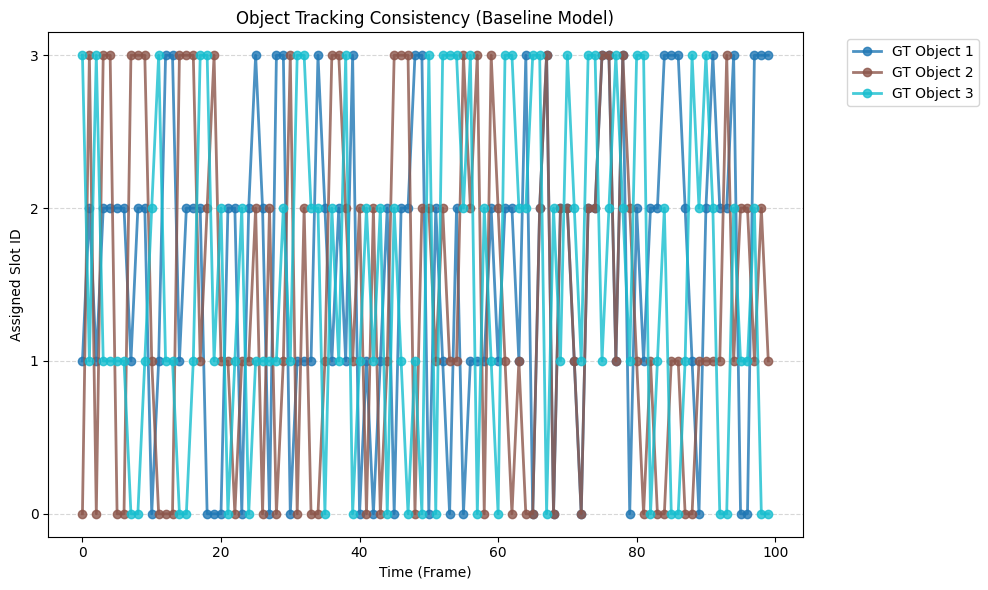

Tracking plot saved to tracking_epoch_500.png


In [ ]:
# @title 4. 学習と評価関数の定義（ID一貫性・可視化機能付き）

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import adjusted_rand_score
import os

# === 評価指標の定義 ===

def compute_ari_score(pred_masks, gt_masks):
    """
    ARI (Adjusted Rand Index) を計算します。
    クラスタリングの品質（スロットが物体領域を正しく捉えているか）を測ります。
    """
    # pred_masks: (B, T, K, 1, H, W) -> ID化
    # gt_masks: (B, T, H, W)

    # マスクからスロットIDを取得 (Argmax)
    pred_ids = torch.argmax(pred_masks.squeeze(3), dim=2).cpu().numpy().flatten()
    gt_ids = gt_masks.cpu().numpy().flatten()

    # Scikit-learnの関数を使用
    return adjusted_rand_score(gt_ids, pred_ids)

def compute_id_consistency_metrics(pred_masks, gt_masks):
    """
    ID Consistency (IDの一貫性) を計算します。
    「同じ物体(GT)が、動画全体を通して同じスロットIDで追跡されているか」を0.0~1.0で評価します。
    1.0に近いほど、長期記憶やRe-IDが成功していることを示します。
    """
    # Batchサイズ=1を前提として処理（平均を取る場合は外側でループ）
    # pred_masks: (T, K, 1, H, W)
    # gt_masks: (T, H, W)

    T, K, _, H, W = pred_masks.shape

    # 予測されたスロットIDマップ (T, H, W)
    pred_ids = torch.argmax(pred_masks.squeeze(2), dim=1)

    # 正解ラベルに含まれる物体ID (背景0を除く)
    gt_ids_unique = torch.unique(gt_masks)
    gt_ids_unique = gt_ids_unique[gt_ids_unique != 0]

    consistencies = []

    for gt_id in gt_ids_unique:
        # このGT物体が存在する全フレーム・全画素のマスク
        target_pixels_mask = (gt_masks == gt_id)

        # 画面内に一度も映っていない場合はスキップ
        if not torch.any(target_pixels_mask):
            continue

        # 対象物体の領域において、予測されたスロットIDを抽出
        predicted_slots = pred_ids[target_pixels_mask]

        # 最も頻繁に割り当てられたスロットID (Dominant Slot) を特定
        counts = torch.bincount(predicted_slots.cpu(), minlength=K)
        most_freq_count = counts.max().item()
        total_pixels = counts.sum().item()

        # 一貫性スコア = (Dominant Slotの画素数) / (その物体の全画素数)
        # 途中でIDが入れ替わると、このスコアが下がります
        consistency = most_freq_count / total_pixels if total_pixels > 0 else 0
        consistencies.append(consistency)

    # 全物体の平均を返す
    avg_consistency = sum(consistencies) / len(consistencies) if consistencies else 0
    return avg_consistency

# === 可視化関数の定義 ===

def save_video_visualization(real, recon, masks, filename="output.mp4"):
    """
    元動画、再構成動画、各スロットのマスクを連結して動画保存します。
    """
    real = real.permute(0, 2, 3, 1).cpu().detach().numpy() # (T, H, W, 3)
    recon = recon.permute(0, 2, 3, 1).cpu().detach().numpy()
    masks = masks.squeeze(2).cpu().detach().numpy() # (T, K, H, W)

    T, H, W, _ = real.shape
    K = masks.shape[1]

    frames = []
    for t in range(T):
        # キャンバス作成: [Input] [Recon] [Slot1] [Slot2] ...
        canvas = np.zeros((H, W * (2 + K), 3))

        # 画像を配置
        canvas[:, :W, :] = real[t]
        canvas[:, W:2*W, :] = recon[t]

        # マスクを配置 (RGB変換して表示)
        for k in range(K):
            m = masks[t, k]
            # マスクの輝度を強調表示
            canvas[:, (2+k)*W:(3+k)*W, :] = np.stack([m, m, m], axis=-1)

        # 0-255のuint8に変換
        frames.append((np.clip(canvas, 0, 1) * 255).astype(np.uint8))

    imageio.mimsave(filename, frames, fps=10)
    print(f"Video saved to {filename}")

def plot_id_tracking(pred_masks, gt_masks, filename="tracking_plot.png"):
    """
    トラッキングの可視化グラフを作成します。
    縦軸: スロットID, 横軸: 時間
    線が水平であればIDが一貫しており、上下に飛ぶとIDスイッチが発生しています。
    """
    T, K, _, H, W = pred_masks.shape

    # GT物体IDのリスト (背景除く)
    gt_ids_unique = torch.unique(gt_masks)
    gt_ids_unique = gt_ids_unique[gt_ids_unique != 0].cpu().numpy()

    # 予測IDマップ
    pred_slots_video = torch.argmax(pred_masks.squeeze(2), dim=1) # (T, H, W)

    # データを収集: track_data[gt_id] = [slot_t0, slot_t1, ...]
    track_data = {gid: [] for gid in gt_ids_unique}
    time_steps = list(range(T))

    for t in range(T):
        for gid in gt_ids_unique:
            # 時刻tにおけるその物体の領域
            gt_mask_t = (gt_masks[t] == gid)

            if not torch.any(gt_mask_t):
                # 物体が隠れている、または画面外
                track_data[gid].append(None)
                continue

            # その領域で最も支配的なスロットIDを取得
            pred_in_region = pred_slots_video[t][gt_mask_t]
            counts = torch.bincount(pred_in_region.cpu(), minlength=K)
            dominant_slot = torch.argmax(counts).item()

            track_data[gid].append(dominant_slot)

    # プロット
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(gt_ids_unique)))

    for i, gid in enumerate(gt_ids_unique):
        sequence = track_data[gid]
        # Noneを除外してプロット
        valid_times = [t for t, s in enumerate(sequence) if s is not None]
        valid_slots = [sequence[t] for t in valid_times]

        if valid_times:
            plt.plot(valid_times, valid_slots, 'o-', label=f'GT Object {gid}',
                     color=colors[i], linewidth=2, markersize=6, alpha=0.8)

    plt.title("Object Tracking Consistency (Baseline Model)")
    plt.xlabel("Time (Frame)")
    plt.ylabel("Assigned Slot ID")
    plt.yticks(range(K))
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Tracking plot saved to {filename}")

# === 学習実行ブロック ===

# モデルとオプティマイザの初期化
model = SlotAttentionVideoBaseline(resolution=(64, 64), num_slots=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=4e-4)

num_epochs = 500 # 必要に応じて増やしてください
print_interval = 10

print("Start Training...")

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_loss = 0

    for i, (video, _) in enumerate(train_loader):
        video = video.to(device)

        optimizer.zero_grad()
        recon_video, _ = model(video)

        # 再構成誤差 (MSE Loss)
        loss = F.mse_loss(recon_video, video)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")

    # --- Evaluation Phase ---
    model.eval()
    with torch.no_grad():
        # 検証用データを1つ取得
        val_video, val_gt_masks = next(iter(val_loader))
        val_video = val_video.to(device)

        recon_val, masks_val = model(val_video)

        # 指標1: ARI (クラスタリング精度)
        ari = compute_ari_score(masks_val, val_gt_masks)

        # 指標2: ID Consistency (長期記憶・一貫性)
        id_con = compute_id_consistency_metrics(masks_val[0], val_gt_masks[0].to(device))

        print(f"Epoch [{epoch+1}] Validation ARI: {ari:.4f}, ID Consistency: {id_con:.4f}")

        # 最終エポックで可視化結果を保存
        if epoch == num_epochs - 1:
            print("Generating visualizations...")
            # 動画保存
            save_video_visualization(
                val_video[0], recon_val[0], masks_val[0],
                filename=f"video_epoch_{epoch+1}.mp4"
            )
            # トラッキンググラフ保存
            plot_id_tracking(
                masks_val[0], val_gt_masks[0].to(device),
                filename=f"tracking_epoch_{epoch+1}.png"
            )

In [ ]:
# @title 5. 動画の表示 (Colab内再生)
from IPython.display import Video
Video(f"video_epoch_{num_epochs}.mp4", embed=True, width=800)